# Homework 5


For this homework, we will be exploring a gene expression dataset profiling T cells derived from thymic and peripheral blood sources, as described in the study [GSE139242](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139242) and the accompanying paper [PMID: 32393182](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6755-1). 


### Prep
Start by Installing and Importing the necessary packages. Note that we will need to set some specific settings to get everything to run properly in Colaboratory.




In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import scipy 
from scipy import stats
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
import csv
import os
import sys
import argparse
from time import time

In [2]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns',10)

# We're also going to tell Jupyter to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
%matplotlib inline

# and this command will allow multiple outputs from the same cell, rather than just the last one run
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Setting up some other Pandas and python presets

In [3]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [4]:
from scipy.signal.signaltools import _centered as trim_centered

In [ ]:
pip install pydeseq2

In [5]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

### Importing Data

Let's start by importing the datasets `GSE139242_gene_counts.csv` and `GSE139242_meta.csv`: 

In [ ]:
# A way to bring in Data
#from google.colab import files
#uploaded = files.upload()

In [6]:
import pandas as pd


# Upload the data_counts dataframe from the file pathway
data_counts = pd.read_csv(r'C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 5\GSE139242_gene_counts.csv', index_col=0)
data_counts = data_counts.transpose()

data_counts


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0
CD8_thymus_1,47.0,806.0,120.0,166.0,291.0,...,2561.0,3149.0,3201.0,8527.0,5869.0
CD8_thymus_2,9.0,226.0,89.0,18.0,42.0,...,576.0,935.0,746.0,1851.0,1868.0


In [7]:
# importing the metadata
#meta = pd.read_csv('GSE139242_meta.csv',index_col = 0)
#meta.shape
#meta
meta = pd.read_csv(r'C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 5\GSE139242_meta.csv', index_col=0)
meta.shape
meta


(16, 3)

,CellType,Source,Replicate
SampleID,,,
CD4_thymus_1,CD4,thymus,1
CD4_thymus_2,CD4,thymus,2
CD4_thymus_3,CD4,thymus,3
CD4_thymus_4,CD4,thymus,4
CD4_bloodinfant_1,CD4,blood,1
CD4_bloodinfant_2,CD4,blood,2
CD4_bloodinfant_3,CD4,blood,3
CD4_bloodinfant_4,CD4,blood,4
CD8_thymus_1,CD8,thymus,1


Let's focus on the CD4 T-cells of the thymus and vs. the blood, as we did in HW4.

In [8]:
# Extracting the samples that are CD4 T-cells from the count data frame.
keepCD4 = meta.CellType == 'CD4' # Create a mask that selects the CD4 samples based on the metadata
countsCD4 = data_counts.loc[keepCD4,:]

In [10]:
# print 'countsCD4' for the sake of sanity 

countsCD4

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0


In [12]:
# Extracting the samples that are CD4 T-cells from the meta data frame
metaCD4 = meta.loc[keepCD4,['Source','Replicate']]
metaCD4

,Source,Replicate
SampleID,,
CD4_thymus_1,thymus,1
CD4_thymus_2,thymus,2
CD4_thymus_3,thymus,3
CD4_thymus_4,thymus,4
CD4_bloodinfant_1,blood,1
CD4_bloodinfant_2,blood,2
CD4_bloodinfant_3,blood,3
CD4_bloodinfant_4,blood,4


Recall from HW4, that we filtered the dataset to exclude genes with low log2 mean values. We'll apply that filter again for HW5.

<Axes: ylabel='Density'>

(8, 15958)

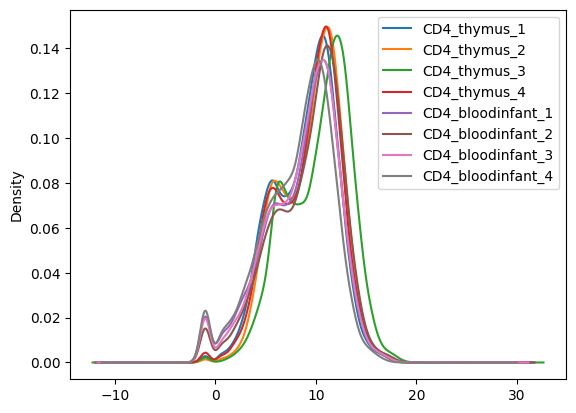

In [13]:

countsCD4_log2 = np.log2(countsCD4 + 0.5) # creates the CD4/infant-specific data frame with the log2-transformed count
meanLog2CD4 = countsCD4_log2.mean() #calculates log2 mean across samples for each gene.
keepMeanAll = meanLog2CD4 > 1 #keeps genes with log2 mean values across samples greater than 1.
countsCD4_log2_meanTrimmed = countsCD4_log2.loc[:,keepMeanAll]
countsCD4_log2_meanTrimmed.transpose().plot(kind='density') #plotting the density plot for the log2-transformed samples, with the trimmed data frame
#countsCD4_log2.transpose().plot(kind='density') # plots the density

countsCD4_meanTrimmed = countsCD4.loc[:,keepMeanAll] #trimming the log2 counts
countsCD4_meanTrimmed.shape

## Questions

1. Run DESeq2 on the `countsCD4_meanTrimmed` dataset, comparing expression from thymus vs. blood. Return a data frame with all of the summary statistics for each gene comparison (baseMean, log2FoldChange, lfcSE, stat, p-value, padj), across all 15,958 genes (rows).

In [14]:
import pandas as pd
import pydeseq2 as pds


In [15]:
# Show countsCD4_meanTrimmed for the sake of sanity 
countsCD4_meanTrimmed

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0


In [16]:
# Print 'metaCD4'  again for the sake of sanity
metaCD4

,Source,Replicate
SampleID,,
CD4_thymus_1,thymus,1
CD4_thymus_2,thymus,2
CD4_thymus_3,thymus,3
CD4_thymus_4,thymus,4
CD4_bloodinfant_1,blood,1
CD4_bloodinfant_2,blood,2
CD4_bloodinfant_3,blood,3
CD4_bloodinfant_4,blood,4


In [17]:
# Create a DeseqDataSet object

dds = DeseqDataSet(counts=countsCD4_meanTrimmed, metadata=metaCD4, design_factors="Source") # Because we are comparing thymus vs blood CD4 cells


In [18]:
# call the dds object! 
dds

AnnData object with n_obs × n_vars = 8 × 15958
    obs: 'Source', 'Replicate'
    obsm: 'design_matrix'

In [19]:
# fit dds 

dds.fit_size_factors()
scaling_deseq = list(dds.obsm["size_factors"])


Fitting size factors...
... done in 0.02 seconds.



In [20]:
dds # call fitted dds 

AnnData object with n_obs × n_vars = 8 × 15958
    obs: 'Source', 'Replicate'
    obsm: 'design_matrix', 'size_factors'
    layers: 'normed_counts'

In [21]:
dds.fit_genewise_dispersions() # fit genewise dispersions

Fitting dispersions...
... done in 4.07 seconds.



In [22]:
# Then, run the DeSeq2 model fit.
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 4.12 seconds.

Fitting dispersion trend curve...
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 4.89 seconds.

Fitting LFCs...
... done in 2.27 seconds.

Replacing 0 outlier genes.



In [23]:
dds # call dds once more after running the model fit

AnnData object with n_obs × n_vars = 8 × 15958
    obs: 'Source', 'Replicate'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [24]:
# Extract the results of the model fit
dds.varm["LFC"]

,intercept,Source_thymus_vs_blood
A1BG,2.68,1.43
A1BG-AS1,5.09,0.65
A2M,1.79,2.04
A2M-AS1,6.78,-2.09
A2ML1,-1.51,5.08
...,...,...
ZXDC,8.21,-0.35
ZYG11B,8.70,-0.12
ZYX,7.65,-0.68
ZZEF1,9.06,-0.57


In [25]:
# Then calculate the statistics
deseq_stats = DeseqStats(dds,alpha = 0.05)
deseq_stats.summary()

Running Wald tests...
... done in 1.69 seconds.



Log2 fold change & Wald test p-value: Source thymus vs blood
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG         38.03            2.06   0.62  3.34  8.34e-04  2.31e-03
A1BG-AS1    237.02            0.93   0.30  3.06  2.23e-03  5.57e-03
A2M          26.38            2.94   0.70  4.23  2.31e-05  9.13e-05
A2M-AS1     496.61           -3.01   0.76 -3.98  6.78e-05  2.41e-04
A2ML1        17.67            7.32   2.01  3.65  2.62e-04  8.10e-04
...            ...             ...    ...   ...       ...       ...
ZXDC       3140.96           -0.51   0.17 -3.05  2.25e-03  5.61e-03
ZYG11B     5641.02           -0.17   0.16 -1.09  2.76e-01  3.60e-01
ZYX        1573.43           -0.99   0.33 -3.03  2.42e-03  5.98e-03
ZZEF1      6743.05           -0.83   0.22 -3.76  1.73e-04  5.56e-04
ZZZ3       9503.89           -0.53   0.13 -4.08  4.51e-05  1.67e-04

[15958 rows x 6 columns]


2. 
* Part A. Filter the results to contain only genes (and their accompanying statistical metrics) that have an adjusted p-value < 0.05 and a DESeq2-calculated absolute log2 fold change value of greater than 1. Sort the genes by descending **DESeq2-calculated log2 fold change (not absolute value)**. What gene with padj < 0.05 is most highly upregulated CD4 T-cells in the blood relative to CD4 T-cells the thymus in this list? 



In [26]:
# PART A: 

# Constraining the results by adjusted p-value and log fold-change
results = deseq_stats.results_df[(deseq_stats.results_df['padj'] < 0.05) &
			(abs(deseq_stats.results_df['log2FoldChange']) > 1)]
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,38.03,2.06,0.62,3.34,8.34e-04,2.31e-03
A2M,26.38,2.94,0.70,4.23,2.31e-05,9.13e-05
A2M-AS1,496.61,-3.01,0.76,-3.98,6.78e-05,2.41e-04
A2ML1,17.67,7.32,2.01,3.65,2.62e-04,8.10e-04
AACS,1361.76,1.08,0.17,6.48,9.30e-11,8.96e-10
...,...,...,...,...,...,...
ZSCAN31,148.06,1.52,0.41,3.66,2.51e-04,7.79e-04
ZSCAN9,146.68,1.11,0.26,4.20,2.67e-05,1.04e-04
ZSWIM1,467.85,-1.15,0.27,-4.30,1.70e-05,6.91e-05
ZWILCH,1782.34,1.65,0.19,8.90,5.35e-19,1.34e-17


In [27]:
# PART A Sorting Step 

#sorting results
results.sort_values('log2FoldChange', ascending=False,) #sorts the results by log2FoldChange in descending order



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
RAG2,4684.22,14.65,1.34,10.94,7.33e-28,4.51e-26
CD1B,7317.35,13.02,0.61,21.25,3.28e-100,4.34e-97
CD1A,5002.44,11.76,0.56,21.11,6.89e-99,8.40e-96
PRSS16,607.05,11.70,1.35,8.67,4.22e-18,9.66e-17
PEX5L,438.98,11.24,1.37,8.22,2.00e-16,3.84e-15
...,...,...,...,...,...,...
HBA1,101.33,-6.37,2.48,-2.57,1.02e-02,2.13e-02
TUBB1,68.79,-7.03,1.61,-4.37,1.27e-05,5.29e-05
PPBP,115.98,-7.42,1.22,-6.07,1.31e-09,1.07e-08
MYCT1,50.67,-7.89,1.32,-5.99,2.12e-09,1.67e-08


Answer to 2A: The gene `RAG2` is the top-listed gene, with a log2 fold change of 14.65 and an adjusted p-value (padj) of 4.51e-26, which is less than 0.05. This indicates that `RAG2` is the most highly upregulated gene in CD4 T-cells in the blood compared to those in the thymus.

Part B. Generate a second filtered gene list that have an adjusted p-value (DESeq2-calculated) < 0.05 and an absolute log2 mean difference (thymus - blood) value of greater than 1, that you calculate **directly from the count data**. Sort the genes by the log2 mean difference values calculated directly from the count data (not absolute value). What gene with padj < 0.05 is most highly upregulated CD4 T-cells in the blood relative to CD4 T-cells the thymus in this list? 


*Hints*: You may need to use `pandas.concat()` to join results output from DESeq2 and the mean log2 fold change values that you calculate directly from the count data to assist in the correct filtering for Part B. 
 
 By default, the DESeq2 calculated fold change values are comparing: `(group alphabetically second) - (group alphabetically first)`.

In [28]:
# print 'countsCD4_log2' for the sake of sanity
countsCD4_log2

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,5.71,7.86,5.57,6.64,1.81,...,10.77,12.22,9.08,11.80,12.71
CD4_thymus_2,5.54,8.27,6.10,6.48,4.55,...,11.66,12.60,10.74,12.60,13.09
CD4_thymus_3,7.46,9.56,6.18,7.96,5.38,...,12.46,13.67,10.30,13.13,14.21
CD4_thymus_4,5.99,8.49,5.27,7.03,6.65,...,11.52,12.04,10.58,12.48,12.77
CD4_bloodinfant_1,4.04,7.34,0.58,8.67,-1.00,...,11.64,12.44,10.80,12.44,13.35
CD4_bloodinfant_2,2.46,6.59,2.46,8.32,-1.00,...,11.82,12.55,11.50,13.08,13.51
CD4_bloodinfant_3,2.70,7.53,2.17,8.06,-1.00,...,11.51,12.40,10.75,12.75,13.10
CD4_bloodinfant_4,4.21,6.59,3.25,10.52,-1.00,...,11.36,11.73,9.96,12.82,12.80


In [29]:
import pandas as pd
import numpy as np

# Assuming 'countsCD4_log2' is a DataFrame with genes as columns and samples as rows
# First, we separate the thymus and blood sample rows
thymus_rows = countsCD4_log2.loc[countsCD4_log2.index.str.contains('thymus')]
blood_rows = countsCD4_log2.loc[countsCD4_log2.index.str.contains('bloodinfant')]

# Calculate the mean for thymus and blood for each gene
mean_thymus = thymus_rows.mean()
mean_blood = blood_rows.mean()

# Compute the absolute difference in expression levels for each gene
abs_diff_expression = np.abs(mean_thymus - mean_blood)


# Assuming 'abs_diff_expression' is your pandas Series
abs_diff_df = abs_diff_expression.to_frame(name='abs_difference')





In [30]:
# sanity check thymus rows 
thymus_rows

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,5.71,7.86,5.57,6.64,1.81,...,10.77,12.22,9.08,11.80,12.71
CD4_thymus_2,5.54,8.27,6.10,6.48,4.55,...,11.66,12.60,10.74,12.60,13.09
CD4_thymus_3,7.46,9.56,6.18,7.96,5.38,...,12.46,13.67,10.30,13.13,14.21
CD4_thymus_4,5.99,8.49,5.27,7.03,6.65,...,11.52,12.04,10.58,12.48,12.77


In [31]:
# sanity check blood rows
blood_rows 


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_bloodinfant_1,4.04,7.34,0.58,8.67,-1.0,...,11.64,12.44,10.80,12.44,13.35
CD4_bloodinfant_2,2.46,6.59,2.46,8.32,-1.0,...,11.82,12.55,11.50,13.08,13.51
CD4_bloodinfant_3,2.70,7.53,2.17,8.06,-1.0,...,11.51,12.40,10.75,12.75,13.10
CD4_bloodinfant_4,4.21,6.59,3.25,10.52,-1.0,...,11.36,11.73,9.96,12.82,12.80


In [32]:
# sanity check mean_thymus 
mean_thymus

A1BG         6.17
A1BG-AS1     8.54
A2M          5.78
A2M-AS1      7.03
A2ML1        4.60
            ...  
ZXDC        11.60
ZYG11B      12.64
ZYX         10.18
ZZEF1       12.51
ZZZ3        13.19
Length: 16031, dtype: float64

In [33]:
#sanity check mean_blood
mean_blood

A1BG         3.35
A1BG-AS1     7.01
A2M          2.12
A2M-AS1      8.90
A2ML1       -1.00
            ...  
ZXDC        11.58
ZYG11B      12.28
ZYX         10.75
ZZEF1       12.77
ZZZ3        13.19
Length: 16031, dtype: float64

In [35]:
# sanity check abs_diff_expression
abs_diff_expression



A1BG        2.82e+00
A1BG-AS1    1.53e+00
A2M         3.66e+00
A2M-AS1     1.87e+00
A2ML1       5.60e+00
              ...   
ZXDC        2.18e-02
ZYG11B      3.56e-01
ZYX         5.77e-01
ZZEF1       2.68e-01
ZZZ3        2.15e-03
Length: 16031, dtype: float64

In [36]:
# Sanity check for abs_diff_df
abs_diff_df

,abs_difference
A1BG,2.82e+00
A1BG-AS1,1.53e+00
A2M,3.66e+00
A2M-AS1,1.87e+00
A2ML1,5.60e+00
...,...
ZXDC,2.18e-02
ZYG11B,3.56e-01
ZYX,5.77e-01
ZZEF1,2.68e-01


In [37]:
# Sanity check for 'results' data frame containing DESEQ2 results
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,38.03,2.06,0.62,3.34,8.34e-04,2.31e-03
A2M,26.38,2.94,0.70,4.23,2.31e-05,9.13e-05
A2M-AS1,496.61,-3.01,0.76,-3.98,6.78e-05,2.41e-04
A2ML1,17.67,7.32,2.01,3.65,2.62e-04,8.10e-04
AACS,1361.76,1.08,0.17,6.48,9.30e-11,8.96e-10
...,...,...,...,...,...,...
ZSCAN31,148.06,1.52,0.41,3.66,2.51e-04,7.79e-04
ZSCAN9,146.68,1.11,0.26,4.20,2.67e-05,1.04e-04
ZSWIM1,467.85,-1.15,0.27,-4.30,1.70e-05,6.91e-05
ZWILCH,1782.34,1.65,0.19,8.90,5.35e-19,1.34e-17


In [38]:
import pandas as pd


# Concatenate the DataFrames 'results' and 'abs_diff_df' 
combined_df = pd.concat([results, abs_diff_df], axis=1,join='inner')


In [39]:
# Show combined_df.......... for sanity
combined_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_difference
A1BG,38.03,2.06,0.62,3.34,8.34e-04,2.31e-03,2.82
A2M,26.38,2.94,0.70,4.23,2.31e-05,9.13e-05,3.66
A2M-AS1,496.61,-3.01,0.76,-3.98,6.78e-05,2.41e-04,1.87
A2ML1,17.67,7.32,2.01,3.65,2.62e-04,8.10e-04,5.60
AACS,1361.76,1.08,0.17,6.48,9.30e-11,8.96e-10,1.62
...,...,...,...,...,...,...,...
ZSCAN31,148.06,1.52,0.41,3.66,2.51e-04,7.79e-04,2.12
ZSCAN9,146.68,1.11,0.26,4.20,2.67e-05,1.04e-04,1.67
ZSWIM1,467.85,-1.15,0.27,-4.30,1.70e-05,6.91e-05,0.68
ZWILCH,1782.34,1.65,0.19,8.90,5.35e-19,1.34e-17,2.20


In [40]:
# Filter the combined DataFrame for genes with adjusted p-value < 0.05 and absolute difference > 1
filtered_combined_df = combined_df[(combined_df['padj'] < 0.05) & 
                                   (combined_df['abs_difference'] > 1)]


In [41]:
filtered_combined_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_difference
A1BG,38.03,2.06,0.62,3.34,8.34e-04,2.31e-03,2.82
A2M,26.38,2.94,0.70,4.23,2.31e-05,9.13e-05,3.66
A2M-AS1,496.61,-3.01,0.76,-3.98,6.78e-05,2.41e-04,1.87
A2ML1,17.67,7.32,2.01,3.65,2.62e-04,8.10e-04,5.60
AACS,1361.76,1.08,0.17,6.48,9.30e-11,8.96e-10,1.62
...,...,...,...,...,...,...,...
ZSCAN2,928.71,1.15,0.14,8.06,7.36e-16,1.32e-14,1.68
ZSCAN31,148.06,1.52,0.41,3.66,2.51e-04,7.79e-04,2.12
ZSCAN9,146.68,1.11,0.26,4.20,2.67e-05,1.04e-04,1.67
ZWILCH,1782.34,1.65,0.19,8.90,5.35e-19,1.34e-17,2.20


In [42]:
# PART B Sorting Step
sorted_df = filtered_combined_df.sort_values(by='abs_difference', ascending=False)


In [43]:
sorted_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_difference
RAG2,4684.22,14.65,1.34,10.94,7.33e-28,4.51e-26,13.94
CD1B,7317.35,13.02,0.61,21.25,3.28e-100,4.34e-97,13.36
CD1A,5002.44,11.76,0.56,21.11,6.89e-99,8.40e-96,12.30
UGT3A2,1833.59,11.06,0.66,16.65,2.89e-62,1.21e-59,11.79
CD1E,9524.67,10.71,0.35,30.91,7.75e-210,1.23e-205,11.33
...,...,...,...,...,...,...,...
KCTD7,996.82,-1.54,0.18,-8.64,5.58e-18,1.26e-16,1.00
ZNF580,423.69,-1.40,0.33,-4.21,2.59e-05,1.01e-04,1.00
MARCHF3,400.28,-1.55,0.25,-6.11,1.03e-09,8.52e-09,1.00
MT-CO2,27737.71,-1.48,0.33,-4.43,9.59e-06,4.10e-05,1.00


Answer to 2B: The gene `RAG2` is once again, the top-listed gene, with a thymus-blood difference of 13.94 and an adjusted p-value (padj) 
of 4.51e-26, which is less than 0.05. This indicates that `RAG2` is the most highly upregulated gene in CD4 T-cells in the blood compared to those in the thymus.

3. Filter the summary statistics results table to extract only genes that have padj < 0.05 and are at least 10-fold higher expressed in CD4 T-cells in the blood than in the thymus (using the DESeq2-calculated log2FoldChange values). Export this results table to a csv file, and download the results table to your computer. Then go to http://bioinformatics.sdstate.edu/go/ and input your gene list for enrichment analysis, looking for enrichment in the KEGG pathway database. What pathways show up as significantly enriched?

In [44]:
# Recall summary stats table from before 
deseq_stats.summary()

Log2 fold change & Wald test p-value: Source thymus vs blood
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG         38.03            2.06   0.62  3.34  8.34e-04  2.31e-03
A1BG-AS1    237.02            0.93   0.30  3.06  2.23e-03  5.57e-03
A2M          26.38            2.94   0.70  4.23  2.31e-05  9.13e-05
A2M-AS1     496.61           -3.01   0.76 -3.98  6.78e-05  2.41e-04
A2ML1        17.67            7.32   2.01  3.65  2.62e-04  8.10e-04
...            ...             ...    ...   ...       ...       ...
ZXDC       3140.96           -0.51   0.17 -3.05  2.25e-03  5.61e-03
ZYG11B     5641.02           -0.17   0.16 -1.09  2.76e-01  3.60e-01
ZYX        1573.43           -0.99   0.33 -3.03  2.42e-03  5.98e-03
ZZEF1      6743.05           -0.83   0.22 -3.76  1.73e-04  5.56e-04
ZZZ3       9503.89           -0.53   0.13 -4.08  4.51e-05  1.67e-04

[15958 rows x 6 columns]


In [47]:


# Corrected filter for summary statistics results table; because logbase 10 of 2 is 3.32
#( looking for genes that are at least 10-fold higher expressed)

filtered_results = combined_df[(combined_df['padj'] < 0.05) & (combined_df['log2FoldChange'] >= 3.32)]


In [48]:
# show filtered_results 
filtered_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_difference
A2ML1,17.67,7.32,2.01,3.65,2.62e-04,8.10e-04,5.60
AADAT,103.33,4.44,0.74,6.04,1.53e-09,1.23e-08,6.16
ABCA8,22.14,5.18,1.08,4.79,1.63e-06,8.11e-06,5.22
ABCA9,28.92,3.52,0.76,4.61,3.99e-06,1.84e-05,3.85
ABHD12B,119.37,6.84,0.65,10.59,3.24e-26,1.71e-24,7.83
...,...,...,...,...,...,...,...
ZNF730,329.55,3.36,0.30,11.16,6.13e-29,4.16e-27,3.97
ZNF750,8.04,5.44,1.63,3.33,8.79e-04,2.42e-03,4.73
ZNF849P,30.32,3.76,0.66,5.70,1.21e-08,8.57e-08,4.60
ZNF887P,17.44,4.55,0.93,4.91,9.33e-07,4.83e-06,5.05


In [49]:
import pandas as pd

# Assuming 'filtered_results' is a pandas DataFrame
filtered_results.to_csv('filtered_results.csv', index=True)



Pathways That Show Up Significantly Enriched:

Amoebiasis,
Hippo signaling pathway-multiple species,
Systemic lupus erythematosus,
ECM-receptor interaction,
Tryptophan metabolism,
Alcoholism,
Protein digestion and absorption,
Renin secretion,
Neutrophil extracellular trap formation,
Viral protein interaction with cytokine and cytokine receptor,
Cell adhesion molecules,
Gap junction,
Estrogen signaling pathway,
Tight junction,
Vascular smooth muscle contraction,
MicroRNAs in cancer,
Focal adhesion,
CGMP-PKG signaling pathway,
Calcium signaling pathway,
Proteoglycans in cancer,
Viral carcinogenesis,
Cytokine-cytokine receptor interaction,
PI3K-Akt signaling pathway,
Pathways in cancer,


4. Create a data frame that has the log2-transformed expression count data of the genes isolated from Question 3 for the all 16 samples in the full dataset. Then calculate the pairwise Pearson correlation coefficient for all pairs of genes. Subtract from this an identity matrix using the `numpy.identity()` function ([info here](https://numpy.org/doc/stable/reference/generated/numpy.identity.html)), in order to get rid of the 1s in the diagonal. Use `unstack()` to select only gene pairs with a correlation greater than 0.95, then export these correlation values (and gene pairs) to a csv file. 

In [50]:
# counts for all 16 samples
data_counts


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0
CD8_thymus_1,47.0,806.0,120.0,166.0,291.0,...,2561.0,3149.0,3201.0,8527.0,5869.0
CD8_thymus_2,9.0,226.0,89.0,18.0,42.0,...,576.0,935.0,746.0,1851.0,1868.0


In [51]:
data_counts_log2 = np.log2(data_counts + 0.5) # log transforms the counts 

In [52]:
data_counts_log2

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,5.71,7.86,5.57,6.64,1.81,...,10.77,12.22,9.08,11.80,12.71
CD4_thymus_2,5.54,8.27,6.10,6.48,4.55,...,11.66,12.60,10.74,12.60,13.09
CD4_thymus_3,7.46,9.56,6.18,7.96,5.38,...,12.46,13.67,10.30,13.13,14.21
CD4_thymus_4,5.99,8.49,5.27,7.03,6.65,...,11.52,12.04,10.58,12.48,12.77
CD4_bloodinfant_1,4.04,7.34,0.58,8.67,-1.00,...,11.64,12.44,10.80,12.44,13.35
CD4_bloodinfant_2,2.46,6.59,2.46,8.32,-1.00,...,11.82,12.55,11.50,13.08,13.51
CD4_bloodinfant_3,2.70,7.53,2.17,8.06,-1.00,...,11.51,12.40,10.75,12.75,13.10
CD4_bloodinfant_4,4.21,6.59,3.25,10.52,-1.00,...,11.36,11.73,9.96,12.82,12.80
CD8_thymus_1,5.57,9.66,6.91,7.38,8.19,...,11.32,11.62,11.64,13.06,12.52
CD8_thymus_2,3.25,7.82,6.48,4.21,5.41,...,9.17,9.87,9.54,10.85,10.87


In [56]:
#slice out the 0th index column from the filtered_results dataframe
filtered_results.iloc[:, 0]


A2ML1       17.67
AADAT      103.33
ABCA8       22.14
ABCA9       28.92
ABHD12B    119.37
            ...  
ZNF730     329.55
ZNF750       8.04
ZNF849P     30.32
ZNF887P     17.44
ZNF99       54.52
Name: baseMean, Length: 818, dtype: float64

In [57]:
import pandas as pd


# Assuming filtered_results is the DataFrame containing the column
column_data = filtered_results.iloc[:, 0]
df_genes = pd.DataFrame(column_data)


In [59]:
df_genes = df_genes.drop('baseMean', axis=1) # drop the 'baseMean' column from the DataFrame

In [60]:
df_genes

""
A2ML1
AADAT
ABCA8
ABCA9
ABHD12B
...
ZNF730
ZNF750
ZNF849P
ZNF887P


In [82]:
column_names = data_counts_log2.columns
print(column_names)


Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'AAAS', 'AACS', 'AADAT',
       'AAGAB', 'AAK1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=16031)


In [85]:
import pandas as pd

# Convert the index of df_genes to a list
genes_of_interest = df_genes.index.tolist()

# Select columns from data_counts_log2 that are in genes_of_interest
filtered_data_counts_16 = data_counts_log2[genes_of_interest]


In [86]:
filtered_data_counts_16

,A2ML1,AADAT,ABCA8,ABCA9,ABHD12B,...,ZNF730,ZNF750,ZNF849P,ZNF887P,ZNF99
CD4_thymus_1,1.81,7.28,5.99,5.77,7.90,...,9.09,4.29,5.82,4.93,6.73
CD4_thymus_2,4.55,7.67,5.82,6.83,7.83,...,9.10,4.36,5.51,5.27,6.01
CD4_thymus_3,5.38,8.72,6.45,6.03,8.97,...,10.60,3.64,7.17,5.71,8.61
CD4_thymus_4,6.65,7.92,3.25,4.43,7.90,...,9.18,4.21,5.82,5.41,5.85
CD4_bloodinfant_1,-1.00,0.58,1.32,1.81,2.70,...,5.15,-1.00,1.32,-1.00,1.81
CD4_bloodinfant_2,-1.00,4.88,-1.00,2.17,-1.00,...,6.73,0.58,2.91,1.32,2.91
CD4_bloodinfant_3,-1.00,-1.00,1.32,3.09,0.58,...,5.38,-1.00,2.70,1.81,2.70
CD4_bloodinfant_4,-1.00,2.46,-1.00,0.58,-1.00,...,4.83,-1.00,-1.00,-1.00,1.32
CD8_thymus_1,8.19,5.89,7.01,7.04,6.59,...,7.78,5.89,4.29,3.75,4.29
CD8_thymus_2,5.41,2.91,4.36,4.43,4.13,...,7.07,3.75,3.25,1.81,3.64


In [88]:
import pandas as pd
import numpy as np

# Let's assume filtered_data_counts_16 is your DataFrame with the log2-transformed expression count data.
# Calculate the Pearson correlation matrix
correlation_matrix = filtered_data_counts_16.corr()

# Subtract the identity matrix to set the diagonal to 0
correlation_matrix -= np.identity(n=correlation_matrix.shape[0])

# Flatten the matrix, reset index to turn it into a DataFrame, and then filter
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Gene1', 'Gene2', 'Correlation']

# Filter out pairs with a correlation greater than 0.95
high_correlation_pairs = correlation_pairs[correlation_pairs['Correlation'] > 0.95]

# Assuming that we do not want to include negative correlations
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Correlation'] > 0]




In [92]:
# Reset the index, and drop the old index
high_correlation_pairs_reset = high_correlation_pairs.reset_index(drop=True)

# Export the DataFrame with the reset index to a CSV file
high_correlation_pairs_reset.to_csv('high_correlation_pairs.csv', index=False)


In [93]:
high_correlation_pairs_reset

,Gene1,Gene2,Correlation
0,A2ML1,ALDH1A3,0.96
1,A2ML1,CALML5,0.98
2,A2ML1,CRYAB,0.96
3,A2ML1,ERICH3,0.95
4,A2ML1,EYA1,0.95
...,...,...,...
63089,ZNF99,ZNF385C,0.97
63090,ZNF99,ZNF423,0.96
63091,ZNF99,ZNF695,0.96
63092,ZNF99,ZNF730,0.98


From the data frame 'data_counts_log2' create a data frame that consists of all the column values for genes which are contained  in the data frame 'df_genes'

5. Find the set of unique genes that are represented in the correlations you selected in Question 4 (you can do this in Excel if you want, though if you would like to do this in python, the `itertools` library may be helpful, information [here](https://www.geeksforgeeks.org/python-convert-list-of-tuples-into-list/#)). Copy this gene set to http://bioinformatics.sdstate.edu/go/ and perform enrichment analysis based on the KEGG pathways. What pathways show up as significantly enriched?

In [97]:
import pandas as pd
import itertools

# Assuming high_correlation_pairs_reset is your DataFrame from the previous steps
# Combine all gene names from 'Gene1' and 'Gene2' into one list
all_genes = list(high_correlation_pairs_reset['Gene1']) + list(high_correlation_pairs_reset['Gene2'])

# Convert the list to a set to keep only unique gene names
unique_genes = set(all_genes)

# Now unique_genes contains all the unique gene names from both columns


In [102]:
# Convert the set to a pandas Series
unique_genes_series = pd.Series(list(unique_genes))

# Save the Series to a CSV file
unique_genes_series.to_csv('unique_genes.csv', index=False)




Pathways That Show Up Significantly Enriched:

Amoebiasis,
Hippo signaling pathway-multiple species,
Systemic lupus erythematosus,
ECM-receptor interaction,
Tryptophan metabolism,
African trypanosomiasis,
Alcoholism,
Protein digestion and absorption,
Renin secretion,
Neutrophil extracellular trap formation,
Drug metabolism-cytochrome P450,
Viral protein interaction with cytokine and cytokine receptor,
Cell adhesion molecules,
Estrogen signaling pathway,
Focal adhesion,
Proteoglycans in cancer,
CGMP-PKG signaling pathway,
Tight junction,
Viral carcinogenesis,
PI3K-Akt signaling pathway,
Cytokine-cytokine receptor interaction,
Pathways in cancer,
Calcium signaling pathway,
